#Transfer Matrices

##Asdex Upgrade Transfer Matrix

In [1]:
using PyPlot
include("src/netcdf.jl")

INFO: Loading help data...


read_ncdf (generic function with 1 method)

In [35]:
a = read_ncdf("data/2962_fida_weights.cdf")

energy = a["energy"] #[keV]
dE = abs(energy[2] - energy[1])
nen = length(energy)

pitch = a["pitch"]
dP = abs(pitch[2] - pitch[1])
np = length(pitch)

wavelength = a["lambda"] # [nm]
dwav = abs(wavelength[2] - wavelength[1])
nwav = length(wavelength)

conv_factor = (1e4)*(1.0/(4*pi))/dwav

channels = [6,12,14,25,32]
blue = [652.7,652.0,652.8,652.4,651.5] # wavelength <= blue
red  = [660.0,660.0,660.8,661.0,659.5] # wavelength >= red

transfer_matrix = eltype(a["wfunct"][1])[]
for (ind,chan) in enumerate(channels)
    wght = a["wfunct"][:,:,:,chan]
    
    wblue = (wavelength .> 649.0) & (wavelength .<= blue[ind])
    wred =  (wavelength .>= red[ind]) & (wavelength .< 663.0)
    
    # We need to flip the pitch dimension since WF were calculated with pitch defined 
    # relative to the magnetic field and not current
    tmat_blue = reshape(flipdim(wght[wblue,:,:],3),sum(wblue),nen*np)
    tmat_red =  reshape(flipdim(wght[wred,:,:],3),sum(wred),nen*np)

    if ind == 1
        transfer_matrix = [tmat_blue, tmat_red]
    else
        transfer_matrix = [transfer_matrix, tmat_blue, tmat_red]
    end
end

transfer_matrix *= conv_factor

transfer_matrix[transfer_matrix .< eps()] = 0.0

# Clear out large unused variables
a = 0
gc()

# reshape transfer matrix so that increasing row index coorespond to increasing pitch 
# and increasing column index cooresponds to increasing energy
nrows,ncols = size(transfer_matrix)
for i=1:nrows
    transfer_matrix[i,:] = reshape(reshape(transfer_matrix[i,:],np,nen)',1,np*nen)
end


###Save AUGD transfer matrix

In [37]:
using NetCDF

nrows, ncols = size(transfer_matrix)

# Write transfer matrix to file
fname = "data/augd_transfer_matrix.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",nrows)
ncols_id = NcDim("ncols",ncols)
nen_id = NcDim("energy",nen)
np_id = NcDim("pitch",np)

t_varid = NcVar("transfer_matrix",[nrows_id,ncols_id])
e_varid = NcVar("energy",nen_id)
p_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[t_varid,e_varid,p_varid])

NetCDF.putvar(ncid,"transfer_matrix",transfer_matrix)
NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid)


131072

###Plot AUGD Integrated Weight Function

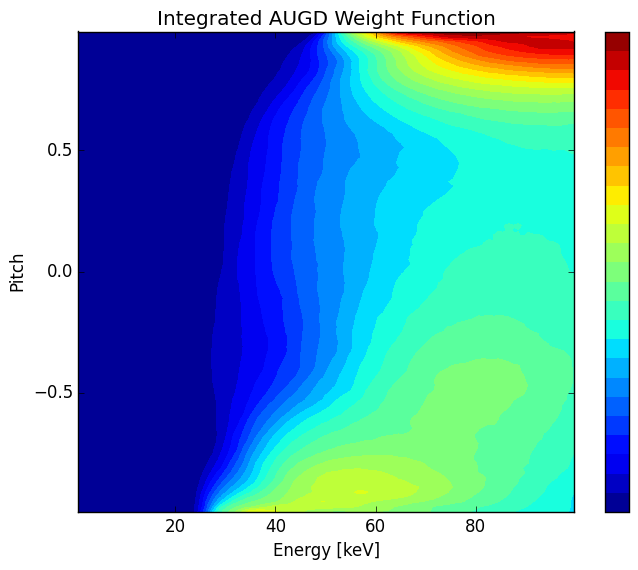

PyObject <matplotlib.colorbar.Colorbar instance at 0x1c394050>

In [38]:
using PyPlot

fig,ax  = plt.subplots()
p = ax[:contourf](energy,pitch,reshape(sum(transfer_matrix,1),np,nen),30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Integrated AUGD Weight Function")
fig[:colorbar](p,ticks=[])

##D3D Transfer Matrix

The D3D transfer matrix is composed of the weight functions for 4 viewing chords. The viewing chords are radially clustered but torodially seperated. As a consequence the D3D transfer matrix is composed of weight functions from chords that view different heating beams at different times since it is not possible to run all the beams simultaneously. This requires multiple FIDASIM runs which produce large files. For memory concerns we will just show the calculated transfer matrix. Rest assured the D3D transfer matrix is calculated in a similar way to the AUGD transfer matrix.

###Plot D3D Integrated Weight Function

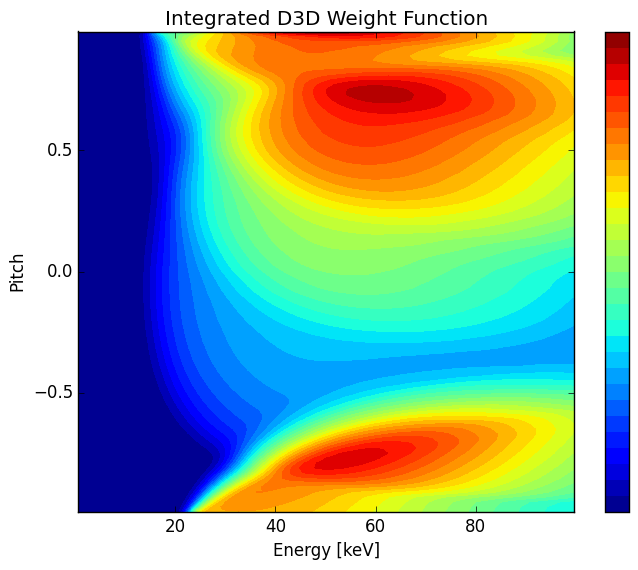

PyObject <matplotlib.colorbar.Colorbar instance at 0x1d531c68>

In [50]:
a = read_ncdf("data/d3d_transfer_matrix.cdf")
d3d_transfer_matrix = a["transfer_matrix"]
a = 0; gc();

fig,ax  = plt.subplots()
p = ax[:contourf](energy,pitch,reshape(sum(d3d_transfer_matrix,1),np,nen),30)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Integrated D3D Weight Function")
fig[:colorbar](p,ticks=[])